In [83]:
%matplotlib inline

import os
import json
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

In [2]:
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0'
mol = Chem.MolFromHELM(HELM_string1)

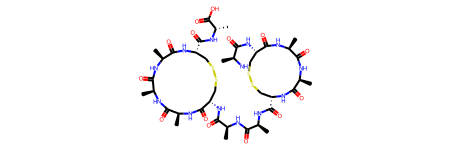

In [3]:
mol

In [4]:
HELM_string1.split('$')

['PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}',
 'PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3',
 '',
 '',
 'V2.0']

In [40]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

In [98]:
class Mutate:
    
    def __init__(self, monomer_library, seed=None):
        self._monomer_library = monomer_library
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)
        
    def mutate(self, helm_string, n=10, minimum_mutations=1, maximum_mutations=None, keep_connections=True):
        mutants = {}
        connections_per_peptide = defaultdict(list)
        peptides, connections, hydrogen_bonds, attributes, _ = helm_string.split('$')
        
        # Process connections
        for connection in connections.split('|'):
            pep_id1, pep_id2, con = connection.split(',')
            connections_per_peptide[pep_id1].append(int(con.split(':')[0]))
            connections_per_peptide[pep_id2].append(int(con.split(':')[1].split('-')[1]))
        
        # Process peptides
        for peptide in peptides.split('|'):
            pep_id = peptide.split('{')[0]
            sequence = peptide[len(pep_id) + 1:-1].replace('.', '')
            mutated_sequences = []
            
            # Residues involved in a connection within and between peptides won't be mutated
            if keep_connections and pep_id in connections_per_peptide:
                possible_positions = list(set(range(len(sequence))).difference(connections_per_peptide[pep_id]))
            else:
                possible_positions = list(range(len(sequence)))
            
            if maximum_mutations is None:
                maximum_mutations = len(sequence)
            
            for i in range(n):
                if minimum_mutations == maximum_mutations:
                    number_mutations = maximum_mutations
                else:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=maximum_mutations)

                mutation_positions = self._rng.choice(possible_positions, size=number_mutations, replace=False)

                mutant = list(sequence)

                for mutation_position in mutation_positions:
                    # This should be replaced by a probability matrix in order to avoid
                    # the generation of very far distant sequence...
                    monomer = self._monomer_library[self._rng.choice(len(self._monomer_library))]
                    mutant[mutation_position] = monomer['symbol']

                mutated_sequences.append(''.join(mutant))
            
            mutants[pep_id] = mutated_sequences
        
        print(mutants)
            
        for connection in connections.split('|'):
            print(connection)

In [100]:
m = Mutate(monomer_aa1_lib)
m.mutate(HELM_string1, maximum_mutations=1, keep_connections=True)

{'PEPTIDE1': ['ACAACAACAMACA', 'ACAACAACAAAKA', 'ACAAAAACAAACA', 'HCAACAACAAACA', 'AEAACAACAAACA', 'ACAACAACAAAYA', 'ACAAAAACAAACA', 'ACAACAACAACCA', 'ACAACAACAFACA', 'ACAGCAACAAACA']}
PEPTIDE1,PEPTIDE1,2:R3-5:R3
PEPTIDE1,PEPTIDE1,8:R3-12:R3


In [85]:
l = defaultdict(list)

In [86]:
l['test'].append(1)

In [88]:
l['test']

[1]